<center><img src="../../logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 3, Lab 3: Implementing a CNN by Using PyTorch

This hands-on notebook will show you how to build a convolutional neural network (CNN) by using PyTorch. 

You will learn how to do the following:

- Use built-in PyTorch CNN architectures to train a multiclass classification model.
- Design a CNN model architecture.
- Train a model by using a CNN.
- Evaluate performance of a CNN model.

---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="../../activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="../../challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |


---
## Index

- [Introduction of a real-world example](#Introduction-of-a-real-world-example)
- [Load the dataset](#Load-the-dataset)
- [Design the model architecture](#Design-the-model-architecture)
- [Define the loss function, optimizer, and evaluation metric](#Define-the-loss-function,-optimizer,-and-evaluation-metric)
- [Train the model](#Train-the-model)
- [Evaluate the model](#Evaluate-the-model)

In [1]:
%%capture
# Install libraries
!pip install -U -q -r requirements.txt

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import SGD

Matplotlib is building the font cache; this may take a moment.



---
## Introduction of a real-world example

The [Materials in Context Database (MINC)](http://opensurfaces.cs.cornell.edu/publications/minc) from Cornell University is a large-scale dataset of images of real-world materials. This lab uses a subset of the MINC dataset. The dataset is well-labeled and a moderate size, which makes it a good fit for this example.

Reference: Sean Bell, Paul Upchurch, Noah Snavely, and Kavita Bala. "Material Recognition in the Wild with the Materials in Context Database." *Computer Vision and Pattern Recognition (CVPR)*, April 2015. https://arxiv.org/abs/1412.0623.

The following image provides examples of images from multiple classes of the dataset.

![MINC 2500 Examples by class](images/MINC-2500.png)

---
## Load the dataset

First, load the dataset that you will use to train the CNN model. In this example, you will use the MINC-2500 dataset with the following classes: 
- Brick
- Carpet
- Food
- Mirror
- Sky
- Water

To start, define the training, validation, and test paths.

In [3]:
path = 'data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

A good practice is to visualize the dataset. To do this, define the `show_images` function.

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../../activity.png" alt="Activity" width="100" /> </p>
    <p style="text-align: center; margin: auto;">To load sample images from the test data, run the following cell. To see different images, run the cell multiple times.</p><br>
    <p style="text-align: center; margin: auto;">To display a 4x4 grid of images, update the call to the <code>show_images</code> function.</p>
    <br>
</div>

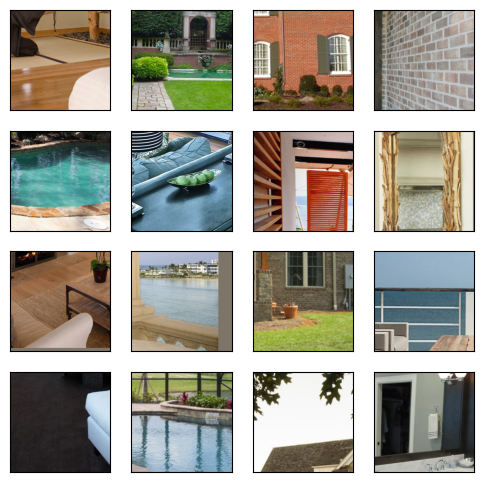

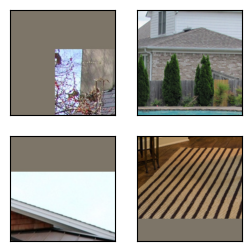

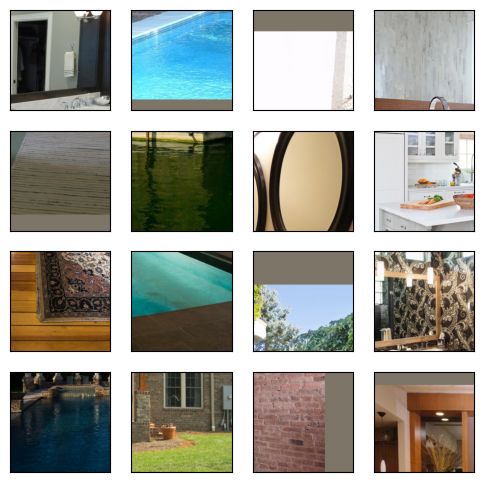

In [8]:
test_dataset = ImageFolder(test_path, transform=transforms.ToTensor())
test_sample = DataLoader(test_dataset, batch_size=2*8, shuffle=True)

for data, label in test_sample:
    show_images(data, 4, 4);
    break
    
for data, label in test_sample:
    show_images(data, 2, 2);
    break

for data, label in test_sample:
    show_images(data, 4, 4);
    break

To load the dataset, you first need to prepare the image data by using `transfoms` functions as follows:
1. Load the image data and resize it to the given size (224,224).
1. Convert the image tensor of shape (C x H x W) in the range [0, 255] to a `float32` torch tensor of shape (C x H x W) in the range (0, 1) using the `ToTensor` class.
1. Normalize a tensor of shape (C x H x W) with its mean and standard deviation by using the `Normalize` function.

In [26]:
transformation = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

Now that you have defined a transformation, you can load the train, validation, and test sets and apply the transformation to them.

In practice, reading data can be a significant performance bottleneck, even when the model is simple or when the computer is fast. Loading the data can take more time than training the model. To speed up the process of loading the dataset, use a PyTorch `DataLoader`. A data loader reads a minibatch of data with size `batch_size` each time.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../../activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To load the train and validation sets, run the following cell.</p><br>
    <p style=" text-align: center; margin: auto;">For a large dataset, you can adjust the <code>batch_size</code> to improve load speed.</p><br>
    <p style=" text-align: center; margin: auto;"><b>Note:</b> This dataset is small, and the Amazon SageMaker instance is fast, so adjusting the batch size here would have little impact on the data load.</p>
    <br>
</div>

In [27]:
batch_size = 16
batch_size = 32

train_loader = DataLoader(
    ImageFolder(train_path, transform=transformation),
    batch_size=batch_size, shuffle=True)

validation_loader = DataLoader(
    ImageFolder(val_path, transform=transformation),
    batch_size=batch_size, shuffle=False)

<div style="border: 4px solid coral; text-align: center; margin: auto;"> 
   <h3><i>Try it yourself!</i></h3>
    <p style="text-align:center; margin:auto;"><img src="../../challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">In the following cell, write code to load the test set.</p>
    <br>
</div>


In [28]:
############### CODE HERE ###############

test_loader = DataLoader(
    ImageFolder(test_path, transform=transformation),
    batch_size=batch_size, shuffle=True)

############## END OF CODE ##############

---
## Design the model architecture

Now you will design a CNN. First, initialize a `Sequential` block. In PyTorch, `Sequential` defines a container for several layers that will be chained together. Given input data, a `Sequential` passes it through the first layer, in turn passing the output as the second layer’s input and so forth.

You want to build a neural network with a 2D convolutional layer `Conv2D`, followed by a 2D max pooling layer `MaxPool2D`, a fully connected (or `Dense`) layer, and a final output `Dense` layer with six output classes. The following figure shows a diagram of the CNN architecture that you will build in this notebook.

<center><img src="images/cnn.png" width="250px" alt="CNN architecture"></center>

In [29]:
# Use GPU resource if available; otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

out_classes = 6

net = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
    nn.ReLU(),
    # First max pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Second convolutional layer
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
    nn.ReLU(),
    # Second max pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),
    # The flatten layer collapses all axes,
    # except the first one, into one axis.
    nn.Flatten(),
    # Fully connected or dense Layer
    nn.Linear(53*53*16, 32),
    nn.ReLU(),
    # Output layer
    nn.Linear(32, out_classes)).to(device)

In [30]:
device

device(type='cuda', index=0)

---
## Define the loss function, optimizer, and evaluation metric

The neural network is almost ready to be trained. The last thing to do before training is set the hyperparameters, such as training device (GPU or CPU), the number of epochs to train, and the learning rate of the optimization algorithm.

In [31]:
epochs = 15
learning_rate = 0.01

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../../activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To specify the loss function, run the following cell.</p><br>
    <p style=" text-align: center; margin: auto;">Because this is a multiclass classification task, use <code>CrossEntropyLoss</code> as the loss function. Different problem types use different loss functions. For example, mean squared error (MSE) is commonly used for regression problems.</p>
    <br>
</div>

In [32]:
criterion = nn.CrossEntropyLoss()

Now, you need to instantiate the `optim.<Optimizer>`, which defines the parameters to optimize over (which are obtained from the network by using `net.parameters()`) and the hyperparameters that the optimization algorithm requires.

In [33]:
optimizer = SGD(net.parameters(), lr=learning_rate)

Finally, define a function to calculate the accuracy, `calculate_accuracy(output, label)`. This function is called for each batch of data. The function uses the network's outputs and the corresponding labels.

In [34]:
def calculate_accuracy(output, label):
    """Calculate the accuracy of the trained network. 
    output: (batch_size, num_output) float32 tensor
    label: (batch_size, ) int32 tensor """
    
    return (output.argmax(axis=1) == label.float()).float().mean()

In [35]:
from datetime import datetime

---
## Train the model

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../../activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">It's time to train the model! Run the following cell.</p><br>
    <p style=" text-align: center; margin: auto;">This code will train 15 epochs (15 full passes through the dataset).</p>
    <br>
</div>

In [36]:
epochs = 20
train_losses = []
train_accs = []
val_losses = []
valid_accs = []

for epoch in range(epochs):
    #You set the device in the "Design the model architecture" section
    net = net.to(device)

    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.

    # Training loop
    # This loop trains the neural network (weights are updated)
    net.train() # Activate training mode
    for data, label in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Put data and label to the correct device
        data = data.to(device)
        label = label.to(device)
        # Make forward pass
        output = net(data)
        # Calculate loss
        loss = criterion(output, label)
        # Make backward pass (calculate gradients)
        loss.backward()
        # Accumulate training accuracy and loss
        train_acc += calculate_accuracy(output, label).item()
        train_loss += loss.item()
        # Update weights
        optimizer.step()

    # Validation loop
    # This loop tests the trained network on the validation dataset
    # No weight updates here
    # torch.no_grad() reduces memory usage when not training the network
    net.eval() # Activate evaluation mode
    with torch.no_grad():
        for data, label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            # Make forward pass with the trained model so far
            output = net(data)
            # Accumulate validation accuracy and loss
            valid_acc += calculate_accuracy(output, label).item()
            val_loss += criterion(output, label).item()

    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    valid_accs.append(valid_acc)

    print("At %s, Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        datetime.now().strftime("%H:%M:%S"), epoch + 1, train_loss, train_acc, val_loss, valid_acc))

At 18:56:29, Epoch 1: train loss 1.777, train acc 0.240, val loss 1.727, val acc 0.318
At 18:56:35, Epoch 2: train loss 1.663, train acc 0.297, val loss 1.479, val acc 0.349
At 18:56:41, Epoch 3: train loss 1.565, train acc 0.336, val loss 1.478, val acc 0.422
At 18:56:48, Epoch 4: train loss 1.444, train acc 0.385, val loss 1.313, val acc 0.458
At 18:56:54, Epoch 5: train loss 1.357, train acc 0.463, val loss 1.255, val acc 0.485
At 18:57:00, Epoch 6: train loss 1.303, train acc 0.485, val loss 1.252, val acc 0.498
At 18:57:07, Epoch 7: train loss 1.226, train acc 0.519, val loss 1.191, val acc 0.528
At 18:57:13, Epoch 8: train loss 1.191, train acc 0.547, val loss 1.153, val acc 0.564
At 18:57:19, Epoch 9: train loss 1.121, train acc 0.581, val loss 1.154, val acc 0.571
At 18:57:25, Epoch 10: train loss 1.099, train acc 0.589, val loss 1.249, val acc 0.484
At 18:57:31, Epoch 11: train loss 1.018, train acc 0.614, val loss 1.098, val acc 0.577
At 18:57:37, Epoch 12: train loss 0.973, 

You might notice that the training loss and accuracy improve, while the validation loss and accuracy mostly fluctuate. This is a signal of overfitting.

---
## Evaluate the model


<div style="border: 4px solid coral; text-align: center; margin: auto;"> 
    <h3><i>Try it yourself!</i></h3>
    <p style="text-align:center; margin:auto;"><img src="../../challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">In the following cell, write code that computes the test accuracy by using the evaluation function.</p>
    <br>
</div>


In [37]:
test_acc = 0.
net.eval() # Activate evaluation mode
with torch.no_grad():
############### CODE HERE ###############

    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        test_acc += calculate_accuracy(output, label).item()


############## END OF CODE ##############

test_acc = test_acc/len(test_loader)

print("Test accuracy: %.3f" % test_acc)

Test accuracy: 0.570


In [38]:
# Plot the training losses
def plot_results(train_losses, train_accs, test_losses, test_accs):
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, "b",  label="Training Loss")
    plt.plot(test_losses, "orange", label="Validation Loss")
    plt.title("Loss values")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, "g", label="Train Accuracy")
    plt.plot(test_accs, "red", label="Validation Accuracy")
    plt.title("Accuracy values")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

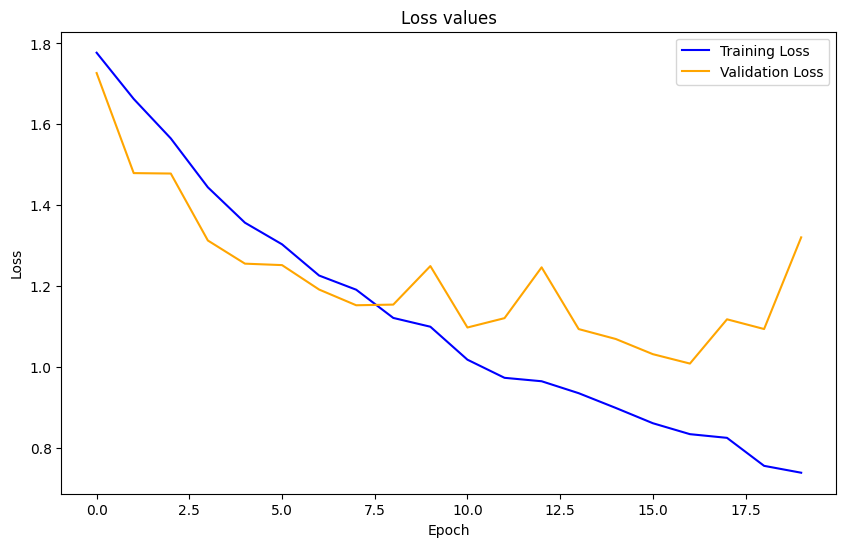

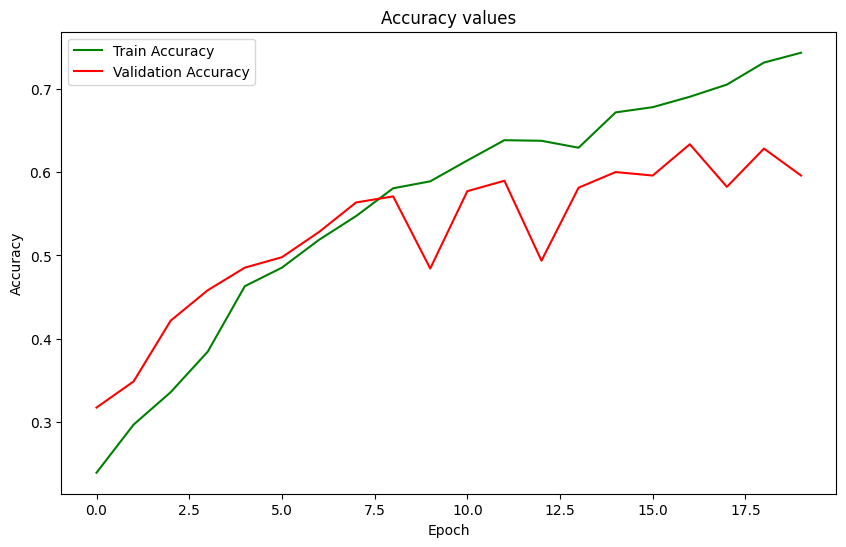

In [42]:
plot_results(train_losses, train_accs, val_losses, valid_accs)

Now that you have designed a CNN model and evaluated its accuracy, you are ready to build a model with a more modern architecture that performs better.

----
## Conclusion

In this lab, you learned the basic steps to build a CNN by using PyTorch. You began by importing the necessary packages and modules, and then you loaded the MINC-2500 dataset by using data loaders that you created for the training and test sets.

Then, you defined the architecture of the CNN, including specifying the layers of the network and how they're connected. After that, you instantiated the CNN model, and defined the loss function and optimizer that you used to train the model. These steps form the foundation of building a CNN with PyTorch.

--- 
## Next lab
In the next lab, you will learn how to build a model by using a modern architecture, ConvNeXt, with PyTorch. 